# Parámetros

In [1]:
BASE_DIR = '/Users/efrain.flores/Desktop/EF/EF/CENIC/nlp-case'

# Código

In [2]:
# Control de datos
from pathlib import Path

# Ingeniería de variables
from numpy import nan
from re import sub, UNICODE, I
from nltk.corpus import stopwords
from unicodedata import normalize
from pandas import DataFrame, read_csv
from nltk.stem import WordNetLemmatizer

# Modelos
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer

# Gráficas
import seaborn as sns
import matplotlib.pyplot as plt

# No queremos ver warnings (por ahora)
import warnings
warnings.filterwarnings("ignore")

class CENIC:
    def __init__(self, base_dir: str) -> None:
        '''
        Sólo recibe el directorio donde está la carpeta de datos y cuenta con los métodos suficientes para:
            - limpieza
            - entrenamiento
            - predicción
        '''
        # Define el directorio como objeto Path para manejar eficientemente los archivos y directorios
        self.base_dir = Path(base_dir)
        # Encuentra todos los archivos en el directorio base que sean csv
        self.files_list = self.base_dir.glob('*.csv')
        
        # Diccionario para poner los csv en DataFrames
        self.dfs_dict = {}
        for file_chunk in self.files_list:
            # Obtener el nombre del archivo
            file_name = str(file_chunk).split('/')[-1]
            # Sólo el nombre, sin extensión
            just_name = file_name.split('.csv')[0]
            # Guardarlo en el diccionario, la llave será el nombre del archivo sin extensión
            self.dfs_dict[just_name] = read_csv(file_chunk)


    def __len__(self) -> int:
        # Número de csv en el directorio base
        return len(self.dfs_dict)


    def __str__(self) -> str:
        return f'Importados {self.__len__()} archivos:\n{list(self.dfs_dict.keys())}'


    def clean_text(self, text: str, pattern: str="[^a-zA-Z0-9\s]", lower: bool=True, rem_stop_words: bool=True, language: str='english', lemmatize: bool=True) -> str: 
        '''
        Limpieza de texto
        '''
        # Reemplazar acentos: áàäâã --> a
        clean = normalize('NFD', str(text).replace('\n', ' \n ')).encode('ascii', 'ignore')
        # Omitir caracteres especiales !"#$%&/()=...
        clean = sub(pattern, ' ', clean.decode('utf-8'), flags=UNICODE)
        # Mantener sólo un espacio
        clean = sub(r'\s{2,}', ' ', clean.strip())

        # Llevar la palabra a su raíz, ejemplo: running -> run, changed -> change
        if lemmatize:
            lem = WordNetLemmatizer()
            clean = ' '.join([lem.lemmatize(word, pos='v') for word in clean.split()])

        # Eliminar palabras que no aportan a la oración: the, this, you, etc
        if rem_stop_words: clean = ' '.join([word for word in clean.split() if word.lower() not in stopwords.words(language)])

        # Minúsculas si el parámetro lo indica
        if lower: clean = clean.lower()

        # Si el registro resulta vacío, indicar nulo
        if clean in ('','nan'): clean = nan
        return clean

    
    def prepare_data(self, df: DataFrame, col: str, **kwargs) -> DataFrame:
        # Omitir todos los datos sensibles que fueron cubiertos con XXX, XX/XX/XXX, etc
        df[f'{col}_clean'] = df[col].map(lambda sentence: sub('X[X\/]*X', '', str(sentence), flags=I))
        # Aplicar la limpieza a cada comentario
        df[f'{col}_clean'] = df[f'{col}_clean'].map(lambda x: self.clean_text(x, **kwargs)).fillna('EMPTY')
        return df

    
    def train_model(self, df: DataFrame, text_col: str, target_col: str, prep, model, verbose: bool=True, **kwargs) -> tuple: 
        '''
        Escala y entrena un modelo, devuelve el score, el objeto tipo Pipeline y la relevancia de cada variable
        '''
        # Separar el modelo tal que f(X) = y
        X = df[text_col].copy()
        y_encod = LabelEncoder()
        # Las etiquetas serán etiquetadas numéricamente
        y = y_encod.fit_transform(df[target_col].values)

        # Conjunto de entrenamiento y de test
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.87, random_state=22, shuffle=True)

        # Define los pasos del flujo
        pipe_obj = Pipeline(steps=[('prep', prep()), ('model', model(**kwargs))])

        # Entrena y guarda el score en test
        test_score = pipe_obj.fit(X_train, y_train).score(X_test, y_test)
        # Guarda el score en train, para revisar sobreajuste
        train_score = pipe_obj.score(X_train, y_train)

        # Imprime los scores
        if verbose: print(f"Score: {'{:.2%}'.format(test_score)}\nTraining score: {'{:.2%}'.format(train_score)}")
        return (pipe_obj, y_encod), (test_score, train_score), (X_train, y_train), (X_test, y_test)


    def train_multiple(self, preps: list, models: list, **kwargs) -> tuple:
        '''
        Entrena a la combinación de preprocesadores y modelos que se le indiquen,
        elige y guarda al mejor modelo con base en el score en el conjunto de test
        '''
        # Diccionario para mostrar el score de cada modelo
        results = {}
        # Variables auxiliares para sobre-escribir el mejor modelo
        max_score = 0
        best_model = ''
        # Iterar sobre los preprocesadores
        for prep_chunk in preps:
            # Iterar sobre los modelos
            for model_chunk in models:
                # eval('Model') "activa" la clase de Scikit-Learn para el entrenamiento
                model, scores, train, test = self.train_model(prep=eval(prep_chunk), model=eval(model_chunk), verbose=False, **kwargs)
                # Guarda el mejor modelo
                if scores[0] > max_score: 
                    max_score = scores[0]
                    best_model = model
                # Actualiza el diccionario para tener el score de cada modelo, en train y test
                results[f'{model_chunk} with {prep_chunk}'] = {'test_score':scores[0], 'train_score':scores[-1]}

        # Estructura los resultados en una tabla
        results = DataFrame(results).T.style.format('{0:,.1%}')
        return results, best_model, train, test


    def cm_sklearn(self, X, y, fit_model, target_encoder) -> DataFrame:
        '''
        Muestra la matriz de confusión en un mapa de calor
        '''
        # Regresa los números a etiquetas originales
        labels = target_encoder.inverse_transform(fit_model.classes_)
        # Calcula la matriz de confusión, real vs estimado
        cm = DataFrame(confusion_matrix(y_true=y, y_pred=fit_model.predict(X)), index=labels, columns=labels).replace({0:nan}).T
        
        # Define el tamaño de el mapa de calor
        size = len(set(y))//2
        fig, ax = plt.subplots(figsize=(size,size)) 
        # Crea el mapa de calor con base en la distribución % del valor real a través de sus predicciones
        sns.heatmap(DataFrame([cm[col]/cm[col].sum() for col in cm.columns]), annot=True, fmt='.0%',cmap='Blues', linewidths=0.5, ax=ax, cbar=False)
        plt.show()
        return cm


    def pred_new_data(self, df: DataFrame, text_col: str, id_col: str, model, target_encoder, suffix: str='', **kwargs) -> DataFrame:
        '''
        Método para predecir sobre nuevos datos
        '''
        # Limpieza del mensaje del consumidor
        df = self.prepare_data(df, text_col, **kwargs)
        # Predecir el producto, ya con la etiqueta original
        df['pred'] = target_encoder.inverse_transform(model.predict(df[text_col]))

        # Predecir la probabilidad de cada clase
        pred_by_class = DataFrame(model.predict_proba(df[text_col]), index=df.index, columns=target_encoder.classes_)
        df = df.join(pred_by_class)

        # Directorio para guardar resultados
        self.results_dir = self.base_dir.joinpath('results')
        self.results_dir.mkdir(exist_ok=True)

        # Guardar resultados
        df.to_csv(self.results_dir.joinpath(f"full_prediction{'' if suffix=='' else '_'+suffix}.csv"), index=False)
        df[[text_col, 'pred']].to_csv(self.results_dir.joinpath(f"prediction{'' if suffix=='' else '_'+suffix}.csv"), index=False)
        df[[id_col]+list(target_encoder.classes_)].to_csv(self.results_dir.joinpath(f"prediction_proba{'' if suffix=='' else '_'+suffix}.csv"), index=False)
        return df

# Clase

In [3]:
cenic = CENIC(BASE_DIR)
print(cenic)

Importados 2 archivos:
['customer-issues-test', 'customer-issues-train']


# Preparar datos

In [4]:
df = cenic.prepare_data(cenic.dfs_dict['customer-issues-train'], 'consumer-message', rem_stop_words=False, lemmatize=False)
df.head()

,date-received,product,sub-product,issue,sub-issue,consumer-message,state,zip-code,tags,via,resolution,timely-response?,disputed?,complaint-id,consumer-message_clean
0,2016-10-01,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,AL,352XX,NaN,Web,Closed with explanation,Yes,No,2141773,i have outdated information on my credit repor...
1,2016-10-17,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,PA,177XX,Older American,Web,Closed with explanation,Yes,No,2163100,i purchased a new car on the car dealer called...
2,2015-06-15,Credit reporting,NaN,Credit reporting company's investigation,Inadequate help over the phone,An account on my credit report has a mistaken ...,VA,224XX,NaN,Web,Closed with explanation,Yes,No,1420702,an account on my credit report has a mistaken ...
3,2016-02-03,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,This company refuses to provide me verificatio...,TX,752XX,NaN,Web,Closed with explanation,Yes,Yes,1772196,this company refuses to provide me verificatio...
4,2016-02-17,Debt collection,Credit card,Improper contact or sharing of info,Talked to a third party about my debt,This complaint is in regards to Square Two Fin...,NE,693XX,NaN,Web,Closed with explanation,Yes,Yes,1790634,this complaint is in regards to square two fin...


# Entrenamiento

## Modelo

In [5]:
model, scores, train, test = cenic.train_model(df, text_col='consumer-message_clean', target_col='product', prep=TfidfVectorizer, model=LogisticRegression, max_iter=7000, class_weight='balanced')

Score: 84.25%
Training score: 87.01%


## Matriz de confusión

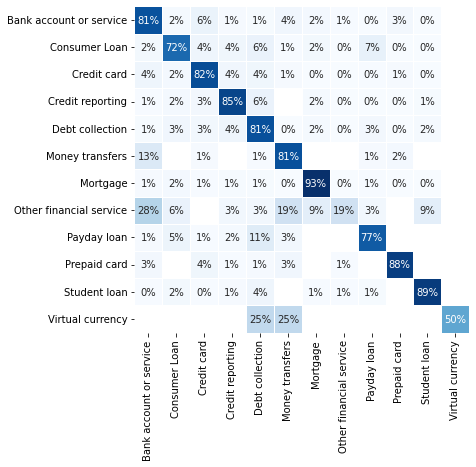

In [7]:
conf_matrix = cenic.cm_sklearn(test[0], test[-1], fit_model=model[0], target_encoder=model[-1])

## Predicción

In [8]:
new_data = cenic.pred_new_data(cenic.dfs_dict['customer-issues-test'], text_col='consumer-message', id_col='complaint-id', model=model[0], target_encoder=model[-1], rem_stop_words=False, lemmatize=False)
new_data.sample().T

,8141
date-received,2017-02-06
consumer-message,I sent XXXX collection agency a letter on XX/X...
state,FL
zip-code,331XX
via,Web
complaint-id,2331011
consumer-message_clean,i sent collection agency a letter on requestin...
pred,Debt collection
Bank account or service,0.001094
Consumer Loan,0.00369


# Si se tiene suficiente tiempo para el entrenamiento:

## Elegir modelo (o crear un ensamble)

In [ ]:
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

results, best_model, train, test = cenic.train_multiple(
    df=df,
    text_col='consumer-message_clean',
    target_col='product',
    preps=['CountVectorizer', 'TfidfVectorizer'],
    models=['XGBClassifier', 'MLPClassifier', 'LogisticRegression', 'RandomForestClassifier']
)

results

## Hiperparametrizar mejor modelo

In [ ]:
from sklearn.metrics import make_scorer, matthews_corrcoef

logreg = LogisticRegression(max_iter=7000)

param_logreg = {
    'penalty':['l1', 'l2', 'elasticnet'], 
    'C':[x+y/10 for x in range(11) for y in range(1,11)], 
    'class_weight':['balanced'],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}


from sklearn.model_selection import GridSearchCV
search_logreg = GridSearchCV(param_grid=param_logreg, cv=4, n_jobs=-1, scoring=make_scorer(matthews_corrcoef), estimator=logreg, verbose=1)


model = Pipeline(steps=[('prep', TfidfVectorizer()), ('model', search_logreg)])
model.fit(train[0], train[-1])

## Matriz de confusión

In [ ]:
confussion_matrix = cenic.cm_sklearn(test[0], test[-1], fit_model=model, target_encoder=best_model[-1])

## Predicción

In [ ]:
new_data = cenic.pred_new_data(cenic.dfs_dict['customer-issues-test'].sample(11), text_col='consumer-message', model=model, target_encoder=best_model[-1], suffix='hiperparam', rem_stop_words=False, lemmatize=False)
new_data.sample().T